## AirBnB Seattle Data Analysis

In this project, there are three bussiness questions which will be tried to answered using the Seattle Data provided by AirBnB website. 
These questions are as following: 

1. What features most influence on the price of the properties?

2. which streets in Seattle host more guests than other streets? What is the average price of these popular streets? what time  they are more busier?

3. How many properties are available during the Year?? How prices change during the calendar period??

In order to answer the above questions, the **CRISP-DM(Cross Industry Standard Process for Data Mining)** is followed while analysing data. 

The steps for this project are as following:

We import the required modules and libraries and also read our three csv data files which are **claendar**, **reviews** and **listings** for the city Seattle:

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
import seaborn as sns
from collections import defaultdict
import itertools
%matplotlib inline

df = pd.read_csv("listings_Seattle.csv")
df_calendar = pd.read_csv("calendar_Seattle.csv")
df_review = pd.read_csv("reviews_Seattle.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### Understand Data:


In [15]:
print("the number of colums and raws of the listings: ",df.shape)
print("the number of the columns and raws of the calendar data is: ", df_calendar.shape)

the number of colums and raws of the listings:  (3818, 92)
the number of the columns and raws of the calendar data is:  (1308890, 4)


In [16]:
# overview of the listing data and understand how to clean it. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

#### Clean Data

#### In order to clean listings data:
- The listings data has 5 columns which are numerical but they are needed to be converted from object type to numericals. 

- There are some boolean value columns which are determined by t and f for **True** and **False** respectively. we replace them with  associated **0** and **1** values. 

- There is a **street** column which is address of the properties and as we need their street name, we extract their street name and put on a new column **street_name**. 

- There is a date column **last_review** and as it is object type we convert them to **date time** objects in order to work better with them.

- At this step we can extract all the **numercial valued columns** which are **float8* and **integer** types select_dtypes() function. 

- It is also good to remove columns with a lot of nan values.  So we put the threshold value to be 0.75 and remove all the columns with more than **%75 nan values**. 

- We then **impute the missing values** with the **mode or mean** of the columns. we fill 4 columns with their mode and fill the rest with mean of the columns

- The last step is to use **categorical values*. In order to use them we make them **dummy variables** and add them to our numerical dataframe. 

In [17]:
def clean_data(df):
    """
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    (df_numerical,df_cat_numeric) - tuple of the cleaned numerical pandas dataframe which is ready for statistical models.
    the first data is cleaned numerical data and second one contains the dummy categorial variables as well. 
    
    """
    # steps to clean data
    
    #1. the columns to convert from object types to floats
    df['zipcode']=df['zipcode'].replace('99\n98122','98122')
    list_df = ['price','security_deposit','cleaning_fee','extra_people','zipcode']
    for obj in list_df:
        df[obj] = df[obj].map(lambda x: x.replace('$','').replace(',',''),na_action='ignore')
        df[obj] = df[obj].astype(float)
        
    # 2. convert boolean columns with strings (f and t) inputs  to 0 and 1 integer values 
    list_boolean =[]
    for cols in df.columns:
        if len(df[cols].value_counts().index)== 2:
            list_boolean.append(cols)
    for cols in list_boolean:
        df[cols] =  df[cols].replace({'f':0,'t':1})
        
    # 3. add new column street_name which is classified based on the street name of each property
    data = []
    string = df['street'].values
    for st in string:
        y = "".join(itertools.takewhile(lambda x: x!=",", st))
        data.append(y)
    df['street_name'] = data    
    
    # 4. convert last_review column to datetime object  
    df['last_review'] =  pd.to_datetime(df['last_review'])

    # 5.  select all the columns with float and integer values 
    df_numeric = df.select_dtypes(include = ['number'])
    
    # 6. drop all the columns with more than %75 of their data with nan values 
    df_numeric = df_numeric.dropna(thresh = 0.75,axis=1)
    
    # 7. fill the missed column values with mode of their associated columns.
    fill_mode  = lambda col:col.fillna(col.mode()[0])
    mode_fills = ['accommodates','bathrooms','bedrooms','beds']
    df_numeric[mode_fills] = df_numeric[mode_fills].apply(fill_mode,axis=0)
    
    # 8. fill the missed values of the remaining columns with the mean of their associated columns 
    fill_mean  = lambda col:col.fillna(col.mean())
    df_numeric = df_numeric.apply(fill_mean,axis=0)
    
    # 9. convert categorical variables to dummies and then include the dummies in the new data set df_numeric
    cat_cols = ['cancellation_policy','room_type','property_type',
                'host_identity_verified','host_has_profile_pic',
                'neighbourhood','host_response_time',
                'street_name','last_review'] # required categorical columns from df
    dummy_df = df[cat_cols]
    for col in  cat_cols:
        dummy_df = pd.concat([dummy_df.drop(col, axis=1), 
                              pd.get_dummies(dummy_df[col], prefix=col, prefix_sep='_', 
                                             drop_first=True, dummy_na=False)], axis=1)
            
    df_cat_numeric = df_numeric.join(dummy_df) #  join dummies and numeric data
    df_cat_numeric = df_cat_numeric.drop(['id','scrape_id','host_id'],axis=1) # drop the unnecessary columns  

    return df_numeric,df_cat_numeric

df_numerical,df_cleaned  = clean_data(df)

#### Predict price of the properties
We use two models to predict prices:

**1. Ridge Regression**.

**2. Random Forest Regression**.

There are two functions which is used for these predictions:

- The data is split to **explanotary** variables(matrix) and **response** variables( vector).
- we then split data to train and test parts. 
- the model is **instantiated** and **fitted** with the **train** data.
- the prices are predicted based on the model and **r-square values** are provided using **sklearn** library. 

There are two r_squared values returned from functions which are related to **train data** and **test data** scores. As much as these values are identical and close to **1**, we have better prediction from our model. 

In [18]:
def predict_with_Ridge(df):
    """
    INPUT
    df - Pandas Dataframe( the input data set is cleaned data ready for our model)
    
    OUTPUT
    r2_score(y_train,y_predict_train),r2_score(y_test,y_predict_test) - the tuple of r-squared values, 
    first one measures r_square between training response vector and predicted ones based
    on training data set and second one measures r_square based on test response vector and predicted ones. 
    
    """
    #Split into explanatory and response variables
    X = df.drop('price',axis=1)
    y = df['price']

    #Split into train and test
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
    lm_model = Ridge()  # Instantiate with Ridge model
    lm_model.fit(x_train,y_train) # fit
    
    #Predict the model and then return scores for the model. 
    y_predict_train = lm_model.predict(x_train)
    y_predict_test = lm_model.predict(x_test) 
    
    return r2_score(y_train,y_predict_train),r2_score(y_test,y_predict_test)

In [19]:
def predict_with_RandomForest(df):
    
    #Split into explanatory and response variables
    X = df.drop('price',axis=1)
    y = df['price']

    #Split into train and test
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
    
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Instantiate with RandomForestRegressor 

    model_rf.fit(x_train, y_train) # fit
    
    #Predict wth Random Forest Regressor and return the scores for the model
    preds_rf = model_rf.predict(x_test)
    preds_rf_train = model_rf.predict(x_train)

    return r2_score(y_train,preds_rf_train),r2_score(y_test,preds_rf)

In [20]:
print("Ridge Regression: the r2_score between train  and predicted train is {} and test  with predicted test is {}"
      .format(predict_with_Ridge(df_cleaned)[0],predict_with_Ridge(df_cleaned)[1]))

Ridge Regression: the r2_score between train  and predicted train is 0.8178805550761346 and test  with predicted test is 0.5934633580752056


In [21]:
print("RandomForest Regression: the r2_score between train  and predicted train is {} and test  with predicted test is {}"
      .format(predict_with_RandomForest(df_cleaned)[0],predict_with_RandomForest(df_cleaned)[1]))


RandomForest Regression: the r2_score between train  and predicted train is 0.9387925470664666 and test  with predicted test is 0.6359849204918233


### **In order to get better predictions, the size of the data must be larger as our categorical variables are large and in order to arrive at better accuracy we might need larger sample of data.** 

#### Answer to question 1:

**What features most influence on the price of the properties?**

In order to find out how different **features** affect the **price** of the properties we use their **correlation** with **price** column:

- The correlation between column **price** and all other columns of the cleaned numerical data is measured and sorted.

- The heatmap from **seaborn** library represents the top 10 highest features which influence on the property price. Not surprisingly, **cleaning_fee** , **accommodates**(number of people who are accepted), **bedrooms**, **beds**, **size** and number of **bathrooms** have highest correlations with price. As there are not very negative correlations(close to -1), we only considered postive ones. 


In [22]:
corr = []  # list to save calculated correlations
features = [] # Coresponding features to save in a list 
for col in df_numerical.columns:
    corr.append(df_numerical[['price',col]].corr().iloc[0].iloc[1]) 
    features.append(col)
    
# build a data frame to match the correlation of price with coresponding feature 
corr_with_price = pd.DataFrame({"correlation": corr}, index = features) 
corr_with_price = corr_with_price.dropna()
corr_with_price = corr_with_price.sort_values(ascending = False, by = 'correlation')# sorted values

 **The correlation of price with itself is obviously 1 and we don't need it. The other 9 features show how they are correlated with price.** 

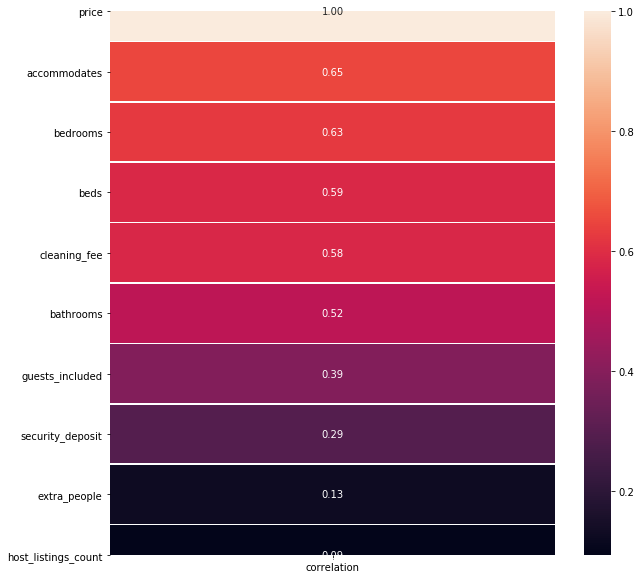

In [23]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr_with_price.head(10), annot=True, fmt=".2f", linewidth = 0.5, ax =ax);

   #### Answer to question 2:



**How many properties are available during the Year?? How prices change during the calendar period??**

To answer  this question we need to use **calendar** data. 


Text(0, 0.5, 'Price')

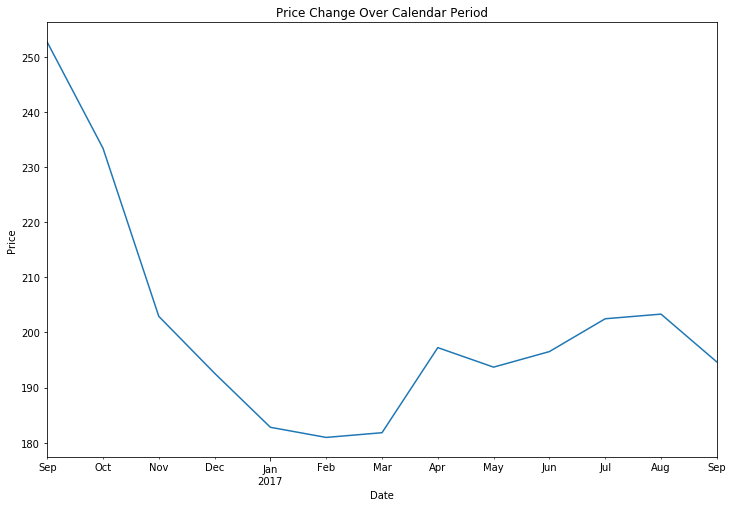

In [24]:
# the price column should be converted to float type
df_calendar['price'] = df_calendar['price'].map(lambda x: x.replace('$','').replace(',',''),na_action='ignore')
df_calendar['price'] = df_calendar['price'].astype(float)

# convert boolean columns with strings (f and t) inputs  to 0 and 1 integer values 
df_calendar['available'] = df_calendar['available'].replace({'f':0,'t':1})

# the index is set to be date column 
df_calendar.index = df_calendar['date']
df_calendar = df_calendar.drop('date',axis=1)

# the date index is object type, so it should be converted to date_time index
df_calendar.index = pd.to_datetime(df_calendar.index)

# the data is resampled from daily to monthly data in order to get better plot from price change
df1 = df_calendar.resample('M').mean() #the average price of the whole properties over each month

# plot
df1['price'].plot(figsize = (12,8))
plt.title("Price Change Over Calendar Period")
plt.xlabel('Date')
plt.ylabel("Price")

It can bee seen that the average **price** is changing over time and it depends on the season and holidays. In summer time specially **September** it is more expensive as **demand** is high and it **drops** as we go to autumn and **winter**. In **April** it goes up again as we have Easter holiday and demand is again becomes high and during **summer** time on average the price of the properties are higher. 

The price average range is between **180 to 250** USD. 

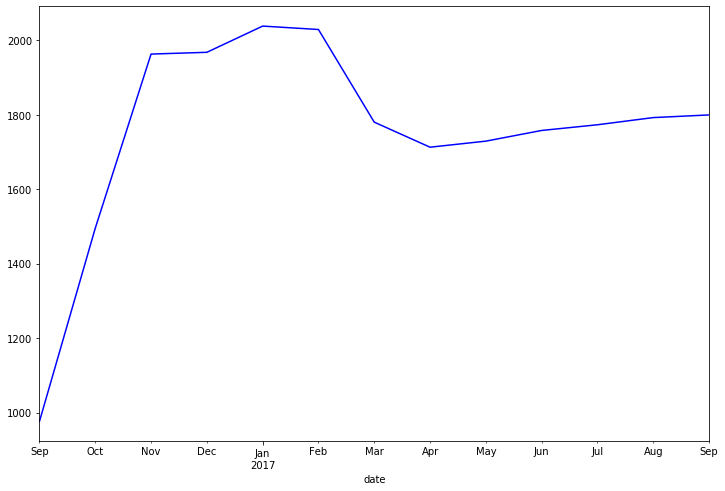

In [29]:
# The whole number of the properties available during the whole data period in 2016 and 2017. 
date_availabilty = df_calendar.groupby('date')['available'].sum().sort_values(ascending = False) # availability based on date 
date_availabilty.resample('M').mean().plot(figsize = (12,8),color = 'b') # plot

 The number of the properties  are available during the period is totally different. In sum up, There are less properties available in Summer as it is the busiest time of the AirBnB. On **January and February**, The number of properties are the highest and they are close to **2000 properties**, but in September it is  less than that. 

#### Answer to  question 3:

- **Which streets in Seattle host more guests than other streets?** 
- **What is the average price of these popular streets?** 
- **what time  they are more busier?**





Text(0, 0.5, 'The Number of Properties')

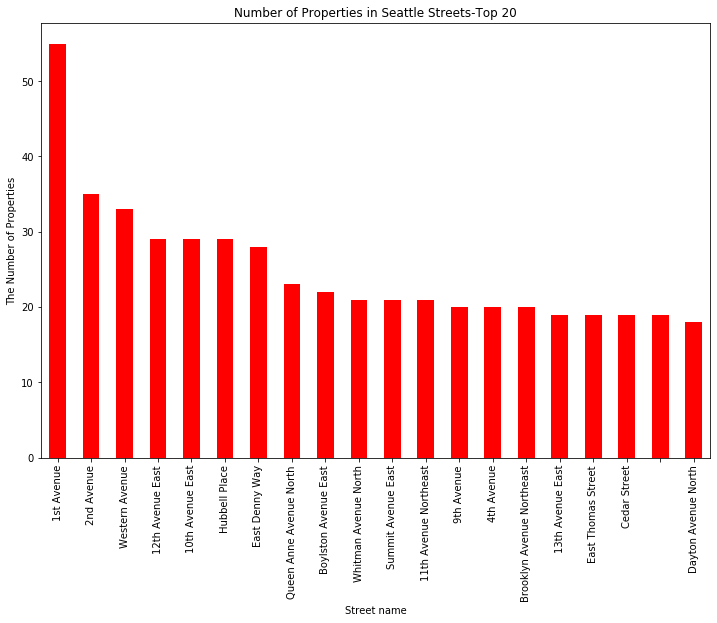

In [26]:
street_values = df['street_name'].value_counts().head(20) # the number of properties in Streets(top 20)
street_values.plot(kind='bar',figsize = (12,8),color ='r')
plt.title("Number of Properties in Seattle Streets-Top 20")
plt.xlabel("Street name")
plt.ylabel("The Number of Properties")

#### It can be seen that 1st Avenue, 2nd Avenue and Western Avenue are the most popular streets in hosting people on AirBnB.

   

Text(0, 0.5, 'The Average price')

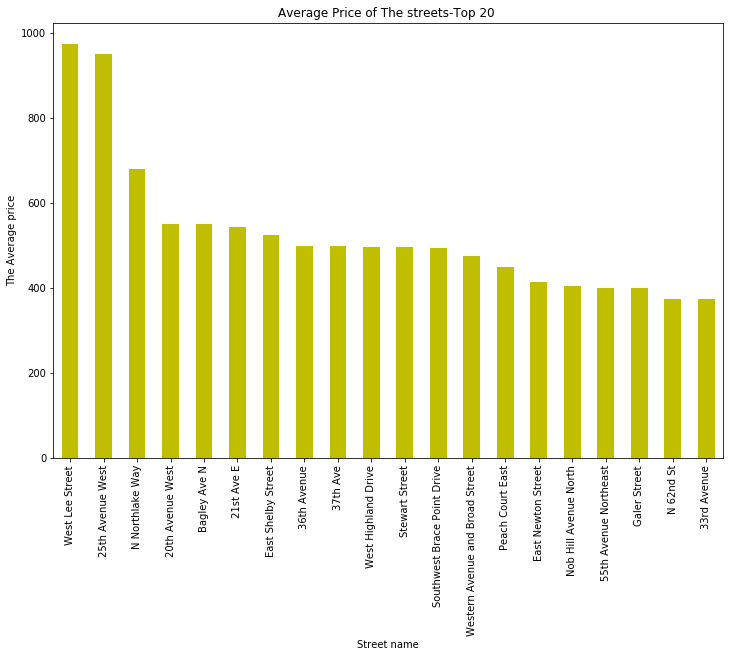

In [27]:
df_price_st = df.groupby('street_name')['price'].mean().sort_values(ascending =False).head(20) # Price of the Properties in streets- top 20
df_price_st.plot(kind = 'bar',color = 'y',figsize  =(12,8)) # plot
plt.title("Average Price of The streets-Top 20 ")
plt.xlabel("Street name")
plt.ylabel("The Average price")

#### The price of the 20 top expensive streets is represented in the plot above. West Lee Street is the most expensive with close to 1000 USD value for one day stay and 33rd Avenue is the least expensive in this plot. 

In [28]:
# availabality of the the properties during the 365 days period(1 year).  
df_availability = df.groupby('id')['availability_365'].sum()/365  # vailabilty of each property in 365 days

# we calculate that how many properties are available during the whole year. 
print(len(df_availability[df_availability == 1])/len(df_availability)*100,"% of properties are available for the whole year")

17.7579884756417 % of properties are available for the whole year


#### Based on the above analysis, only 17.5% of the properties in Seattle  are available for the whole year. In other words, they are full-time working on the AirBnB platform. 